In [ ]:
!pip install skimpy
!pip install fastdtw

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.
jupyterlab 4.2.1 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is i

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import itertools
import warnings
import gc
import re
import scipy
from sklearn.compose import TransformedTargetRegressor
from sklearn import set_config
from colorama import Style, Fore
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict, GroupKFold, TimeSeriesSplit
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import Ridge, RidgeCV
from matplotlib.dates import MonthLocator, DateFormatter
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, HistGradientBoostingRegressor, BaggingRegressor
from lightgbm import LGBMRegressor
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer,mean_squared_error, mean_absolute_error, silhouette_score
from sklearn.linear_model import TweedieRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as DateFormatter
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, HistGradientBoostingClassifier
import math
from fastdtw import fastdtw
from sklearn.cluster       import AgglomerativeClustering
import skimpy

sns.set_theme(style = 'white', palette = 'colorblind')
pal = sns.color_palette('colorblind')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/rohlik-orders-forecasting-challenge/test_calendar.csv
/kaggle/input/rohlik-orders-forecasting-challenge/solution_example.csv
/kaggle/input/rohlik-orders-forecasting-challenge/train.csv
/kaggle/input/rohlik-orders-forecasting-challenge/test.csv
/kaggle/input/rohlik-orders-forecasting-challenge/train_calendar.csv


# Config

In [ ]:
SUBMIT = True

In [ ]:
def printColor(pText: str):
    print(f'{Style.BRIGHT}{Fore.GREEN}{pText}{Style.RESET_ALL}')

# Reading data

In [ ]:
train = pd.read_csv(r'/kaggle/input/rohlik-orders-forecasting-challenge/train.csv',index_col='id')
train_calendar = pd.read_csv(r'/kaggle/input/rohlik-orders-forecasting-challenge/train_calendar.csv')
test = pd.read_csv(r'/kaggle/input/rohlik-orders-forecasting-challenge/test.csv',index_col='id')
test_calendar = pd.read_csv(r'/kaggle/input/rohlik-orders-forecasting-challenge/test_calendar.csv')
sub  = pd.read_csv(r'/kaggle/input/rohlik-orders-forecasting-challenge/solution_example.csv')

In [ ]:
train.head()

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2
id,,,,,,,,,,,,,,,,,
Prague_1_2020-12-05,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0
Prague_1_2020-12-06,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0
Prague_1_2020-12-07,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0
Prague_1_2020-12-08,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0
Prague_1_2020-12-09,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0


In [ ]:
test.head()

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays
id,,,,,,,
Prague_1_2024-03-16,Prague_1,2024-03-16,NaN,0,0,0,0
Prague_1_2024-03-17,Prague_1,2024-03-17,NaN,0,0,0,0
Prague_1_2024-03-18,Prague_1,2024-03-18,NaN,0,0,0,0
Prague_1_2024-03-19,Prague_1,2024-03-19,NaN,0,0,0,0
Prague_1_2024-03-20,Prague_1,2024-03-20,NaN,0,0,0,0


In [ ]:
train_calendar.head()

,date,holiday_name,holiday,shutdown,mini_shutdown,warehouse_limited,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,warehouse
0,2022-03-09,NaN,0,0,0,0,0,1,0,0,0.0,0,0.0,0.0,Prague_1
1,2019-07-03,NaN,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,Prague_1
2,2020-05-18,NaN,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,Prague_1
3,2021-11-09,NaN,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,Prague_1
4,2023-08-02,NaN,0,0,0,0,0,0,0,0,0.0,0,2.5,0.0,Prague_1


# Descriptive Statistics

In [ ]:
print(f'{Style.BRIGHT}{Fore.YELLOW} SHAPE')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> train: {Fore.GREEN} {train.shape}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> train_calendar: {Fore.GREEN} {train.shape}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> test:  {Fore.GREEN} {test.shape}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> test_calendar:  {Fore.GREEN} {test_calendar.shape}')

print(f'\n\n{Style.BRIGHT}{Fore.YELLOW} NULL VALUES')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Train: {Fore.GREEN} {train.isnull().any().any()}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Test:  {Fore.GREEN} {test.isnull().any().any()}')

print(f'\n\n{Style.BRIGHT}{Fore.YELLOW} DUPLICATES')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Train: {Fore.GREEN} {train.duplicated().any().any()}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Test:  {Fore.GREEN} {test.duplicated().any().any()}')

 SHAPE
 -> train:  (7340, 17)
 -> train_calendar:  (7340, 17)
 -> test:   (397, 7)
 -> test_calendar:   (1869, 7)


 NULL VALUES
 -> Train:  True
 -> Test:   True


 DUPLICATES
 -> Train:  False
 -> Test:   False


* For this first moment, only the features that we have in common between the training and test data will be used as a baseline.

In [ ]:
initial_features = list(test.columns)
target = 'orders'
print(f'Initial features: {Style.BRIGHT}{Fore.GREEN} {initial_features} {Style.RESET_ALL}')
print(f'target: {Style.BRIGHT}{Fore.BLUE}{target} {Style.RESET_ALL}')

Initial features:  ['warehouse', 'date', 'holiday_name', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays'] 
target: orders 


In [ ]:
skimpy.skim(train[initial_features+[target]])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7340   │ │ int64       │ 4     │                                                          │
│ │ Number of columns │ 8      │ │ string      │ 3     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name             ┃ NA  ┃ NA %  ┃ mean      ┃ sd       ┃ p0   ┃ p25   ┃ p50  ┃ p75  ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ holiday                 │   0 │     0 │   0.02725 │   0.1628 │    0 │     0 │    0 │    0 │     1 │   ▇    │  │
│ │ shops_closed            │   0 │     0 │    0.0109 │   0.1038 │    0 │     0 │    0 │    0 │     1 │   ▇    │  │
│ │ winter_school_holidays  │   0 │     0 │   0.02997 │   0.1705 │    0 │     0 │    0 │    0 │     1 │   ▇    │  │
│ │ school_holidays         │   0 │     0 │  0.007084 │  0.08388 │    0 │     0 │    0 │    0 │     1 │   ▇    │  │
│ │ orders                  │   0 │     0 │      5535 │     2183 │  790 │  4434 │ 5370 │ 7009 │ 18140 │  ▂▇▅▁  │  │
│ └─────────────────────────┴─────┴───────┴───────────┴──────────┴──────┴───────┴──────┴──────┴───────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA         ┃ NA %        ┃ words per row              ┃ total words            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ warehouse                 │          0 │           0 │                          1 │                   7340 │  │
│ │ date                      │          0 │           0 │                          1 │                   7340 │  │
│ │ holiday_name              │       7122 │       97.03 │                      0.095 │                    697 │  │
│ └───────────────────────────┴────────────┴─────────────┴────────────────────────────┴────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [ ]:
skimpy.skim(test)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 397    │ │ int64       │ 4     │                                                          │
│ │ Number of columns │ 7      │ │ string      │ 3     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━┳━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name               ┃ NA  ┃ NA %   ┃ mean      ┃ sd       ┃ p0  ┃ p25  ┃ p50  ┃ p75  ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━╇━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ holiday                   │   0 │      0 │   0.06801 │   0.2521 │   0 │    0 │    0 │    0 │    1 │ ▇    ▁ │  │
│ │ shops_closed              │   0 │      0 │   0.02015 │   0.1407 │   0 │    0 │    0 │    0 │    1 │   ▇    │  │
│ │ winter_school_holidays    │   0 │      0 │   0.02015 │   0.1407 │   0 │    0 │    0 │    0 │    1 │   ▇    │  │
│ │ school_holidays           │   0 │      0 │   0.07053 │   0.2564 │   0 │    0 │    0 │    0 │    1 │ ▇    ▁ │  │
│ └───────────────────────────┴─────┴────────┴───────────┴──────────┴─────┴──────┴──────┴──────┴──────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA       ┃ NA %         ┃ words per row               ┃ total words            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ warehouse                 │        0 │            0 │                           1 │                    397 │  │
│ │ date                      │        0 │            0 │                           1 │                    397 │  │
│ │ holiday_name              │      380 │        95.72 │                         0.1 │                     40 │  │
│ └───────────────────────────┴──────────┴──────────────┴─────────────────────────────┴────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

## Time (temporal feature)

In [ ]:
for df in [train, test]:
    df['date'] = pd.to_datetime(df['date'])
    df['holiday_name'] = df['holiday_name'].fillna('None')

In [ ]:
freq = train['date'].copy()
freq = freq.to_frame().reset_index()
freq.set_index('date',inplace=True)
print(f'Frequency days: {pd.Series(freq.index.max()-freq.index.min()).value_counts()[0]}')

Frequency days: 1


In [ ]:
print('Train')
print(f'first date (train) : {train.date.min()}')
print(f'last date (train) : {train.date.max()}')
print(f'interval (train) : {train.date.max()-train.date.min()}')
print(50*'*')
print('\nTest')
print(f'first date (test) : {test.date.min()}')
print(f'last date (test) : {test.date.max()}')
print(f'interval (test) : {test.date.max()-test.date.min()}')

Train
first date (train) : 2020-12-05 00:00:00
last date (train) : 2024-03-15 00:00:00
interval (train) : 1196 days 00:00:00
**************************************************

Test
first date (test) : 2024-03-16 00:00:00
last date (test) : 2024-05-15 00:00:00
interval (test) : 60 days 00:00:00


In [ ]:
for  w in train.warehouse.unique():
    print(f'{Style.BRIGHT}{Fore.BLUE}**{w}**{Style.RESET_ALL}')
    print(f'  First date: {train.loc[train.warehouse==w].date.min().strftime("%Y-%m-%d")}')
    print(f'  Last  date: {train.loc[train.warehouse==w].date.max().strftime("%Y-%m-%d")}')
    print(f'{Style.BRIGHT}{Fore.YELLOW} Missing Dates-> {Style.RESET_ALL}{pd.date_range(start=train.loc[train.warehouse==w].date.min(),end=train.loc[train.warehouse==w].date.max()).difference(train.loc[train.warehouse==w].date)}\n')


**Prague_1**
  First date: 2020-12-05
  Last  date: 2024-03-15
 Missing Dates-> DatetimeIndex(['2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25'], dtype='datetime64[ns]', freq=None)

**Brno_1**
  First date: 2020-12-05
  Last  date: 2024-03-15
 Missing Dates-> DatetimeIndex(['2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25'], dtype='datetime64[ns]', freq=None)

**Prague_2**
  First date: 2020-12-05
  Last  date: 2024-03-15
 Missing Dates-> DatetimeIndex(['2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25'], dtype='datetime64[ns]', freq=None)

**Prague_3**
  First date: 2020-12-05
  Last  date: 2024-03-15
 Missing Dates-> DatetimeIndex(['2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25'], dtype='datetime64[ns]', freq=None)

**Munich_1**
  First date: 2021-07-21
  Last  date: 2024-03-15
 Missing Dates-> DatetimeIndex(['2021-07-22', '2021-07-23', '2021-07-24', '2021-07-25',
               '2021-07-26', '2021-07-27', '2021-07-28', '2021-07-30',
               '2021-07-31',

* As we can see, there are series with different periods and also some with data without records, some we know refer to holidays, such as 12/25. Brno_1, Budapest_1, Prague_1, Prague_2 and Prague_3, have their series starting on 2020-12-05 and going until 2024-03-15, while Munich_1 starts on 2021-07-21 and ends on 2024-03-15. Frankfurt_1 starts in 2022. Perhaps we can split these series during our cross-validation.
* Let's try below to find a pattern in the warehouse series, through clustering.

# Clustering

* First, a distance matrix between the time series of orders in different warehouses is calculated using a fast version of Dynamic Time Warping (DTW)

In [ ]:
%%time
dc = train.copy()
list_wh = train.warehouse.unique()
dim_matrix =  dc['warehouse'].drop_duplicates().shape[0]
distance_matrix = np.zeros((dim_matrix,dim_matrix))
for i,v1 in enumerate(list_wh):
    w1 = dc[dc.warehouse==v1]['orders'].values
    for j,v2 in enumerate(list_wh):
        w2 = dc[dc.warehouse==v2]['orders'].values

        distance, path = fastdtw(w1,w2)
        distance_matrix[i][j] = distance

CPU times: user 170 ms, sys: 1.3 ms, total: 171 ms
Wall time: 170 ms


* Now we try to find the number of ideal clusters, using the Silhouette score.
* The Silhouette Score can be used to determine the optimal number of clusters in a clustering analysis, as it provides a measure of how compact and well separated the clusters are. The higher the average Silhouette Score for a given number of clusters, the better the separation between the clusters.

In [ ]:
%%time
max_clusters = 6
clusters = np.arange(2,max_clusters+1)
silhouttes = []
for c in clusters:
    model = AgglomerativeClustering(affinity='precomputed', n_clusters=c, linkage='complete').fit(distance_matrix)
    s = silhouette_score(distance_matrix, model.fit_predict(distance_matrix))
    silhouttes.append(s)

CPU times: user 11.6 ms, sys: 2.72 ms, total: 14.4 ms
Wall time: 15.8 ms


* Agglomerative Clustering is a hierarchical clustering algorithm used to group data. It is a bottom-up approach, where each data point starts as its own cluster and then clusters are iteratively merged based on their proximity, forming a hierarchy of clusters. documentation link: [AgglomerativeClustering_SkLearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

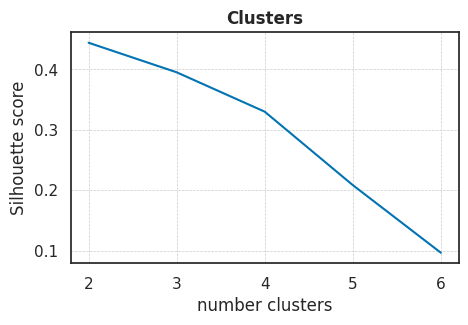

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(clusters,silhouttes)
plt.grid(True,lw=0.5,ls='--')
plt.ylabel('Silhouette score')
plt.xlabel('number clusters')
plt.title('Clusters',fontweight='bold');

* Above we can see that the ideal number of clusters is 2.

In [ ]:
model = AgglomerativeClustering(affinity='precomputed',
                                n_clusters=2,
                                linkage='complete').fit(distance_matrix)
clusters = model.labels_
c = dict(zip(list_wh,clusters))
dc['clusters'] = dc['warehouse'].copy()
dc['clusters'] = dc['clusters'].map(c)
display(dc[['warehouse', 'clusters']].drop_duplicates().groupby('clusters').count().reset_index())
display(pd.DataFrame(list(c.items()), columns=['warehouse', 'cluster']).style.background_gradient(axis=0))

del dc
gc.collect()

,clusters,warehouse
0,0,5
1,1,2


,warehouse,cluster
0,Prague_1,1
1,Brno_1,1
2,Prague_2,0
3,Prague_3,0
4,Munich_1,0
5,Frankfurt_1,0
6,Budapest_1,0


3084

* As we can see, from the results Prague_1 and Brno_1 belong to the same cluster, and the others to another. We can train 2 models, one for each cluster.

# Target

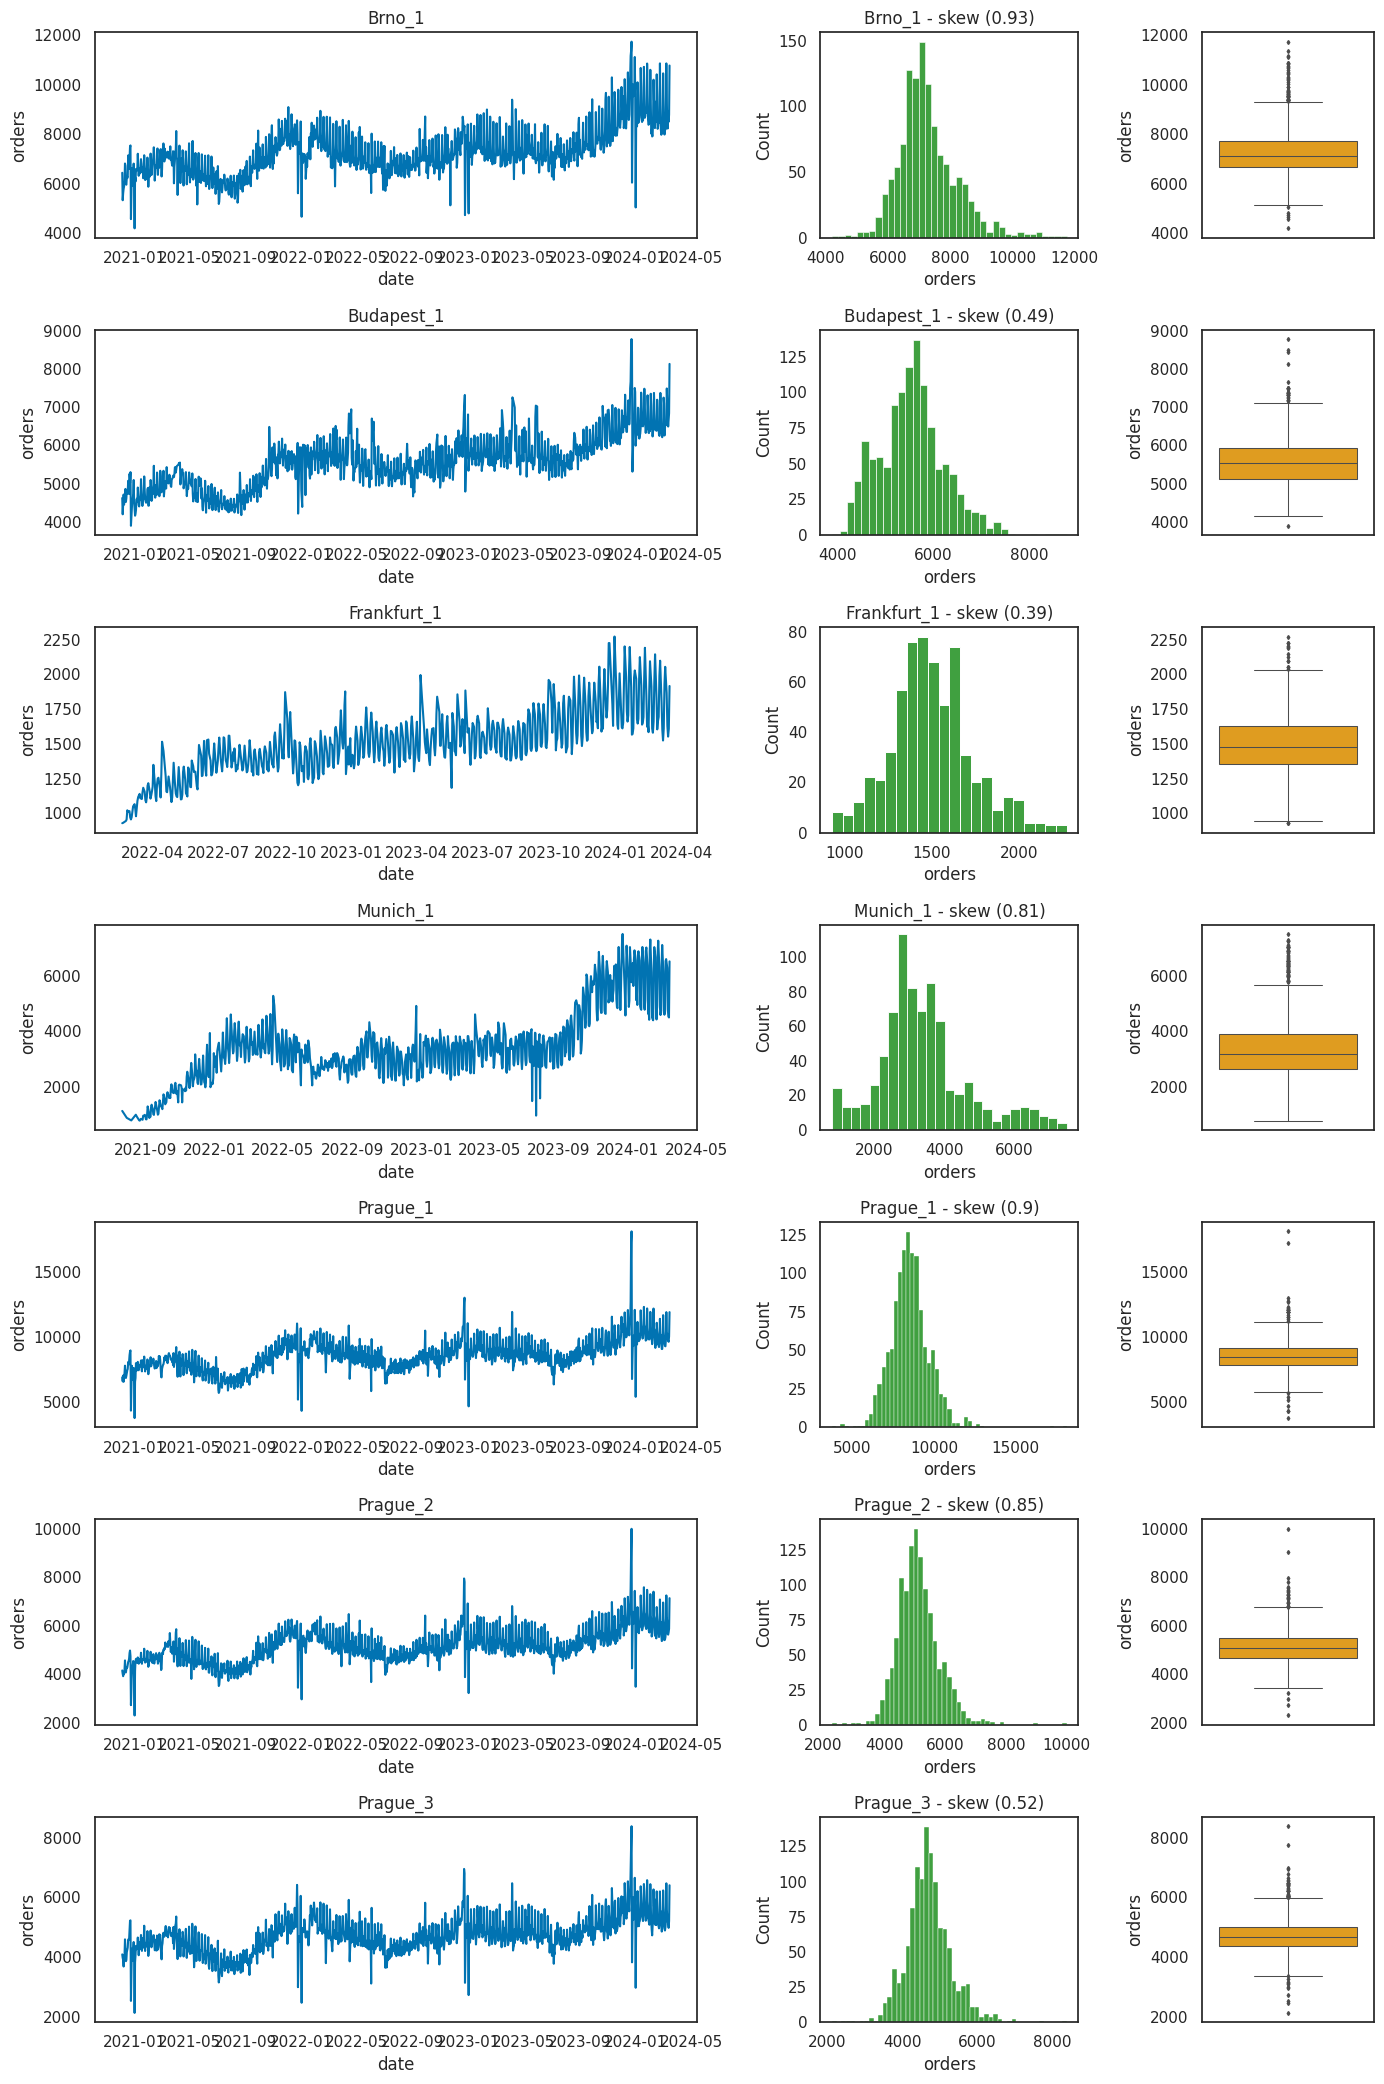

In [ ]:
fig, axes = plt.subplots(7,3, figsize=(14,7*3), gridspec_kw={'width_ratios':[0.70, 0.30, 0.20 ]})

for i,(ind, c) in enumerate(train.groupby('warehouse')):
    ax = axes[i,0]
    sns.lineplot(data=c,x=c.date,y='orders',ax=ax)
    ax.set_title(f'{ind}')

    ax = axes[i,1]
    sns.histplot(data=c,x='orders',ax=ax,color='green')
    ax.set_title(f'{ind} - skew ({c.orders.skew().round(2)})')

    ax = axes[i,2]
    sns.boxplot(data=c,y='orders',ax=ax,color='orange', linewidth=.75, fliersize=2.01, width=0.80)

plt.tight_layout()

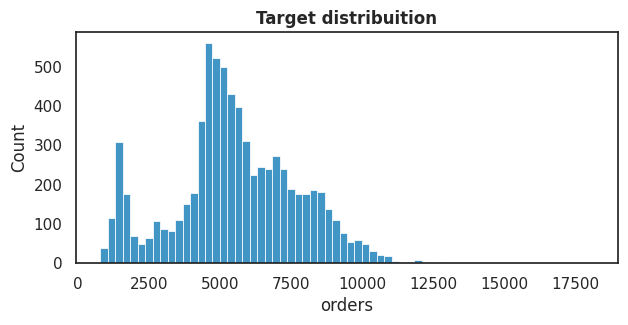

In [ ]:
plt.figure(figsize=(7,3))
sns.histplot(train['orders']);
plt.title('Target distribuition',fontweight='bold');

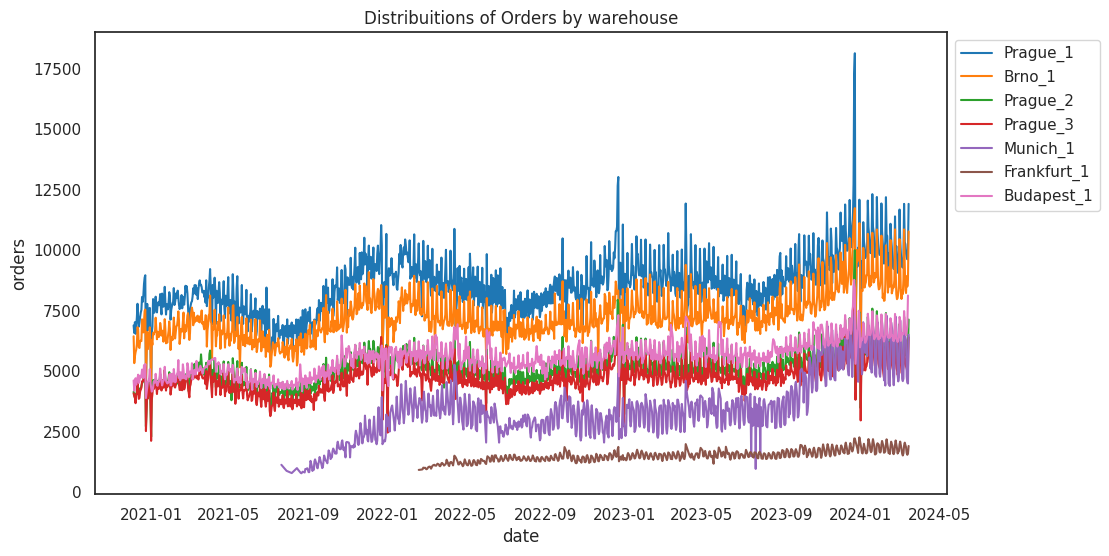

In [ ]:
_, ax = plt.subplots(figsize=(11,6))
sns.lineplot(data=train,x='date',
             y='orders',
             errorbar=None,
             hue='warehouse',
             palette='tab10',ax=ax);
ax.legend(bbox_to_anchor=[1, 1]);
ax.set_title('Distribuitions of Orders by warehouse');

# Trend

First degree polynomial (one line) fitting is often used to model linear trends in time series data.

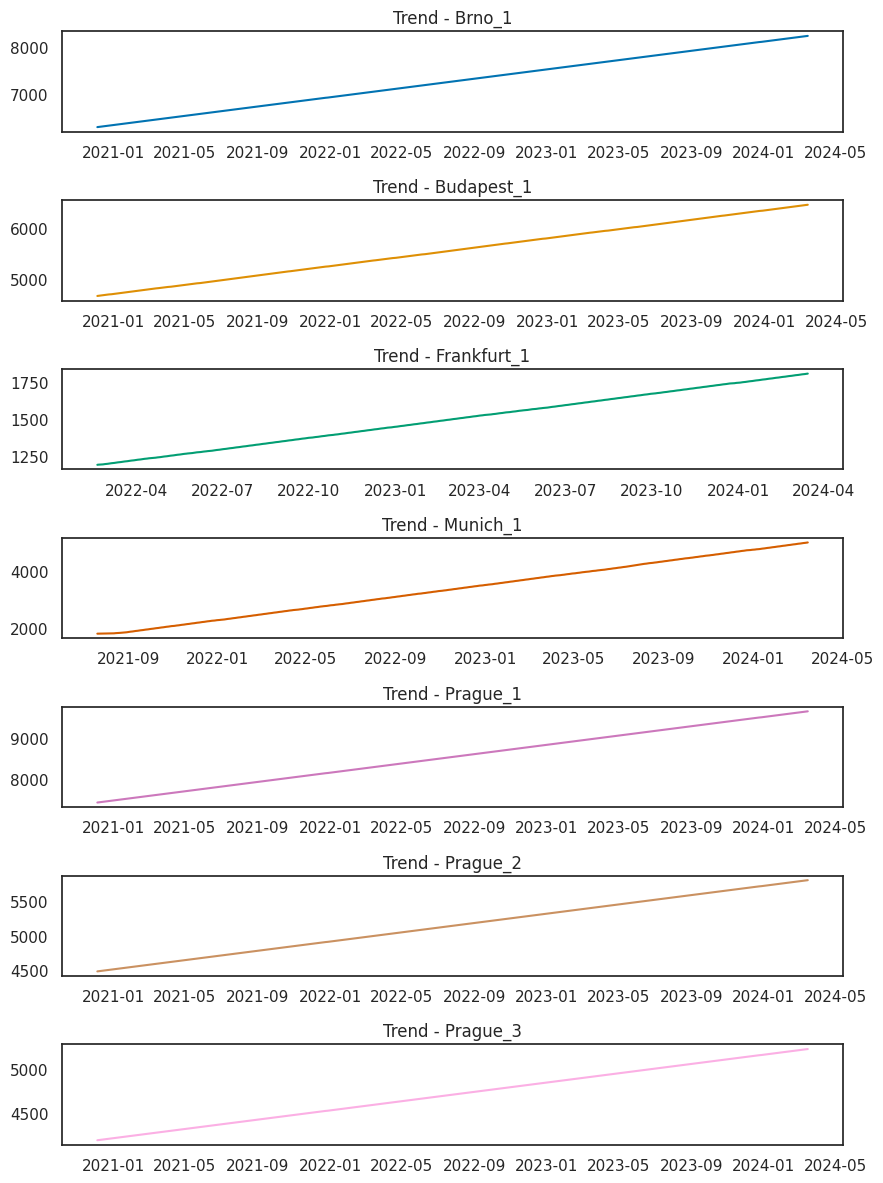

In [ ]:
colors = sns.color_palette()
fig, axes = plt.subplots(7,1, figsize=(9,4*3))
ax = axes.flatten()
for i,(ind, c) in enumerate(train.groupby('warehouse')):
    temp = c.groupby(c.date).orders.mean()
    poly = np.polynomial.polynomial.Polynomial.fit(range(len(temp.index)), temp, deg=1)
    ax[i].plot(temp.index, poly(range(len(temp.index))),color=colors[i])
    ax[i].set_title(f'Trend - {ind}')

plt.tight_layout()

* Above we have the graphs of time series trends of average orders over time for different warehouses. First degree polynomial fitting allows you to visualize the general direction of trends.

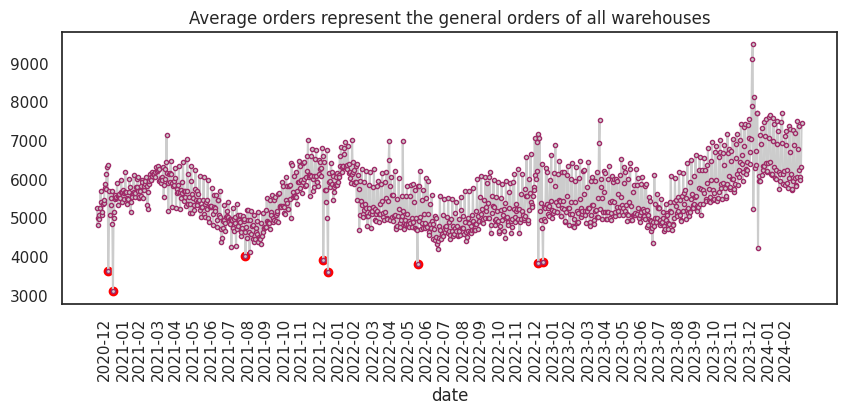

In [ ]:
all_orders = train.copy()
all_orders.reset_index(inplace=True)
all_orders = all_orders.set_index('date')
all_orders = all_orders.set_index(['warehouse'],append=True)
average_orders = all_orders.groupby('date')['orders'].mean()
ax= average_orders.plot(figsize=(10,4),
                        markeredgecolor='#9F2B68',
                        #markerfacecolor='#9F2B68',
                        style='.-',
                        color='0.8')

start_date = average_orders.index.min()
end_date = average_orders.index.max()
smallest_orders = average_orders.nsmallest(8)
largest_orders = average_orders.nlargest(10)
dates_to_plot = pd.date_range(start=start_date, end=end_date, freq='1M')
# for date in dates_to_plot:
#     if date.month == 12:
#         ax.axvline(date, color='red', linestyle='--', linewidth=0.7)

smallest_scatter = ax.scatter(smallest_orders.index,
                              smallest_orders.values,
                              color='red',
                              label='8 Smallest Orders')

legend_labels = []
for date in smallest_orders.index:
    legend_labels.append(f'{date.strftime("%Y-%m")}: {smallest_orders[date]}')

ax.set_xticks(dates_to_plot)
ax.set_xticklabels(dates_to_plot.strftime('%Y-%m'), rotation=90)
ax.set_title('Average orders represent the general orders of all warehouses');

* The graph shows a general trend of increasing average orders over time, with some seasonal fluctuations.
* some seasonal fluctuations in average orders. For example, there appears to be a spike in average orders at the end of the year

# Initial features

In [ ]:
cat_features      = ['warehouse','holiday_name']
num_features      = ['holiday','shops_closed','winter_school_holidays']
temporal_features = ['date']

for df in [train,test]:
    df[cat_features] = df[cat_features].astype('category')

* Some models require the type of categorical variable to be of the Category type (for example LGBM and XGBoost), in addition the category type is more efficient than the 'object'

# Feature distributions

In [ ]:
def plot_numerical():
    df = pd.concat([train[num_features].assign(Source = 'Train'),
                    test[num_features].assign(Source = 'Test')], ignore_index = True)

    fig, axes = plt.subplots(len(num_features), 1 ,figsize = (5, len(num_features) * 2),
                             gridspec_kw = {'hspace': 0.55, 'wspace': 0})
    axes = axes.flatten()

    for i,col in enumerate(num_features):
        ax = axes[i]
        sns.histplot(data = df[[col, 'Source']], x = col, hue = 'Source', palette=['#456cf0', '#ed7647'],ax = ax)
        ax.set_title(f"\n{col}",fontsize = 9)
        ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75)
        ax.set(xlabel = '', ylabel = '')

    plt.suptitle(f'\nDistribution analysis - numerical features',fontsize = 12, y = 1, x = 0.57, fontweight='bold')
    plt.show()

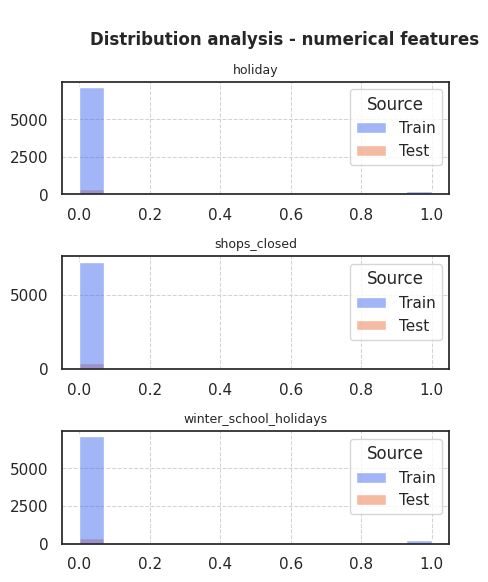

In [ ]:
plot_numerical()

* For all distributions with positive skewness and below zero, applying a logarithmic transformation can help bring them closer to normal. This contributes to some machine learning models.

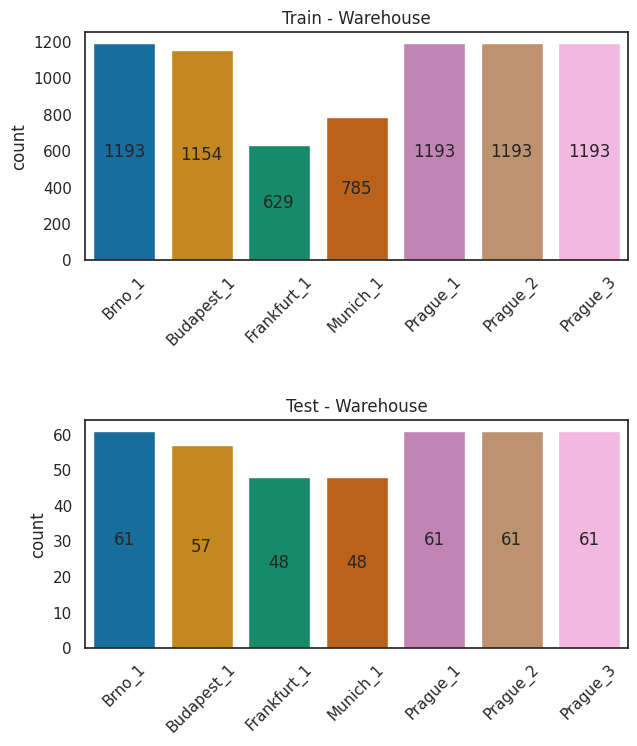

In [ ]:
_,ax = plt.subplots(2,1, figsize=(7,8), gridspec_kw={'hspace':0.70})
ax =ax.flatten()

sns.countplot(data=train, x='warehouse',ax=ax[0])
ax[0].set_xticklabels(labels=ax[0].get_xticklabels(),rotation=45);
vc = train['warehouse'].cat.codes.value_counts() / len(train)
ax[0].bar_label(ax[0].containers[0], label_type='center');
ax[0].set_title('Train - Warehouse')
ax[0].set_xlabel('')

sns.countplot(data=test, x='warehouse',ax=ax[1])
ax[1].set_xticklabels(labels=ax[1].get_xticklabels(),rotation=45);
vc = train['warehouse'].cat.codes.value_counts() / len(train)
ax[1].bar_label(ax[1].containers[0], label_type='center');
ax[1].set_title('Test - Warehouse')
ax[1].set_xlabel('');

# Correlation

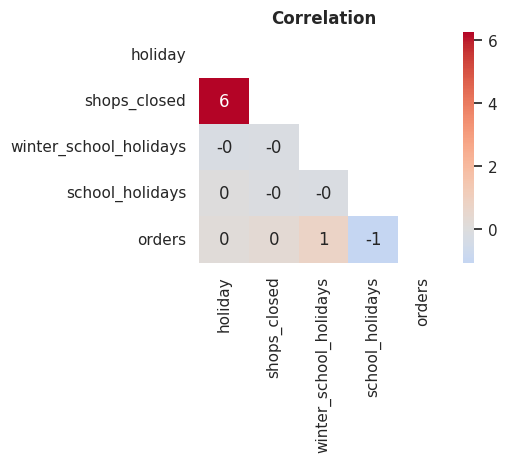

In [ ]:
corr_features = [f for f in initial_features+[target] if f not in ['date','id']+cat_features]
cc = np.corrcoef(train[corr_features], rowvar=False)
mask = np.zeros_like(cc)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(4, 3))
sns.heatmap(cc*10, center=0, cmap='coolwarm', annot=True, fmt='.0f',
            xticklabels=corr_features, yticklabels=corr_features,mask=mask)
plt.title('Correlation',fontweight='bold')
plt.show()

* holiday is correlated with shops_closed.

# Preprocess

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, cols):
        self.cols = cols

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return x[self.cols]

In [ ]:
class DateProcessor(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    def transform(self, X):
        x_copy = X.copy()
        x_copy['year'] = x_copy['date'].dt.year
        x_copy['month'] = x_copy['date'].dt.month
        x_copy['day']   = x_copy['date'].dt.day
        x_copy['dayofweek'] = x_copy['date'].dt.dayofweek
        x_copy['sin_month']=np.sin(2*np.pi*x_copy['month']/12)
        x_copy['cos_month']=np.cos(2*np.pi*x_copy['month']/12)
        x_copy['sin_day']=np.sin(2*np.pi*x_copy['day']/30)
        x_copy['cos_day']=np.cos(2*np.pi*x_copy['month']/30)

        return x_copy.drop('date',axis=1)

# Cross validation

In [ ]:
oof, scores, test_preds   = {}, {}, {}

## Metric

In [ ]:
def MAPE(y_true,y_pred):
    return np.mean(np.abs(y_pred-y_true)/y_true)

In [ ]:
kf = GroupKFold(n_splits=5)
tss = TimeSeriesSplit(n_splits=5)

def cross_validate(model, label=''):

    if label is None:
        label = type(model).__name__

    X = train.copy()
    y = X.pop('orders')

    val_scores_mape, val_scores_mae, dates = [], [], [],

    y_preds = np.zeros((len(train)))
    for i, (trx_idx, val_idx) in enumerate(tss.split(X,y,groups=X['warehouse'])):
        X_train = X.iloc[trx_idx]
        y_train = y.iloc[trx_idx]

        X_val   = X.iloc[val_idx]
        y_val   = y.iloc[val_idx]

        model.fit(X_train,y_train)
        y_pred = model.predict(X_val)
        y_preds[val_idx] += y_pred
        mape = MAPE(y_val,y_pred)
        val_scores_mape.append(mape)
        val_scores_mae.append(mean_absolute_error(y_val,y_pred))

        print(f'Fold {i+1}: MAPE: {mape} | MAE: {mean_absolute_error(y_val,y_pred)} ')


    oof[label] = y_preds
    scores[label] = np.mean(val_scores_mape)
    printColor(f'MAPE: {np.mean(val_scores_mape)} +- {np.std(val_scores_mape)} | MAE: {np.mean(val_scores_mae)} +- {np.std(val_scores_mae)} | {label}')


    if SUBMIT:
        X = train.copy()
        y = X.pop('orders')
        y_preds = np.zeros((len(test)))
        model.fit(X,y)
        y_preds += model.predict(test)
    test_preds[label] = y_preds


In [ ]:
cross_validate(make_pipeline(FeatureSelector(initial_features),
                             DateProcessor(),
                             MEstimateEncoder(cols=cat_features),
                             TransformedTargetRegressor(
                                          XGBRegressor(enable_categorical=False,
                                                       random_state=42,
                                                       n_estimators=100),
                                          func=np.log1p,
                                          inverse_func=np.expm1)
                                          ),'XGB')

Fold 1: MAPE: 0.172973833351148 | MAE: 1194.0677517183667 
Fold 2: MAPE: 0.112972757173056 | MAE: 574.669429002389 
Fold 3: MAPE: 0.284162305280903 | MAE: 674.0603127155944 
Fold 4: MAPE: 1.5120262206190258 | MAE: 2869.465789769969 
Fold 5: MAPE: 0.0808062913924036 | MAE: 431.46746771275167 
MAPE: 0.4325882815633072 +- 0.544154545780627 | MAE: 1148.746150183814 +- 898.0322444150776 | XGB


In [ ]:
params = {'verbose': -1,'random_state': 42}
cross_validate(make_pipeline(FeatureSelector(initial_features),
                             DateProcessor(),
                             OrdinalEncoder(cols='holiday_name'),
                             TransformedTargetRegressor(
                                          LGBMRegressor(**params),
                                          func=np.log1p,
                                          inverse_func=np.expm1)
                                          ),'LGBM')

Fold 1: MAPE: 0.15625459024038466 | MAE: 1075.4096917708046 
Fold 2: MAPE: 0.10008809736449113 | MAE: 548.6263723707426 
Fold 3: MAPE: 0.29649692315281984 | MAE: 724.8929757291181 
Fold 4: MAPE: 0.4240097140093168 | MAE: 1290.6510023376027 
Fold 5: MAPE: 0.17149228682350573 | MAE: 944.8330323988787 
MAPE: 0.22966832231810366 +- 0.11644715563420174 | MAE: 916.8826149214294 +- 260.0336705497971 | LGBM


In [ ]:
cross_validate(make_pipeline(FeatureSelector(initial_features),
                             DateProcessor(),
                             ColumnTransformer([('ohe', OneHotEncoder(), cat_features)],remainder='passthrough'),
                             TransformedTargetRegressor(
                                          RandomForestRegressor(
                                                       random_state=42,
                                                       verbose=0,
                                                       max_depth=9),
                                          func=np.log1p,
                                          inverse_func=np.expm1)
                                          ),'RF')

Fold 1: MAPE: 0.17611895831268976 | MAE: 1199.676781762825 
Fold 2: MAPE: 0.16094294484856558 | MAE: 851.8208142597286 
Fold 3: MAPE: 0.4676309357645079 | MAE: 1067.9622460085072 
Fold 4: MAPE: 1.4405325855629494 | MAE: 2761.2993756873375 
Fold 5: MAPE: 0.11816963787473261 | MAE: 649.6436178342922 
MAPE: 0.47267901247268906 +- 0.499513795661542 | MAE: 1306.0805671105381 +- 751.3914123346945 | RF


In [ ]:
result = []
for label in oof.keys():
    score = MAPE(train['orders'], oof[label])
    result.append((label, score))
result_df = pd.DataFrame(result, columns=['label', 'score'])
result_df.sort_values('score', inplace=True, ascending=False)
result_df

,label,score
2,RF,0.560686
0,XGB,0.527286
1,LGBM,0.358232


# Submission

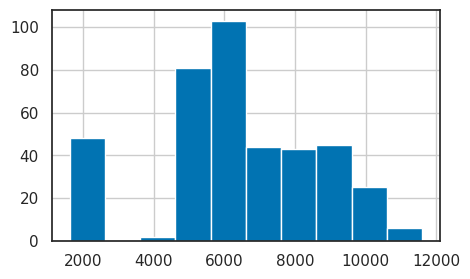

In [ ]:
if SUBMIT:
    sub['orders'] = test_preds['LGBM']*1.01
    sub['orders'].hist(figsize=(5,3))
    sub.to_csv('submission.csv',index=False)

* LGBM obtained better results in this first stage, and also obtained a lower standard deviation in relation to the others.
* For better results, you must: tune the LGBM hyperparameters, and adapt the cross-validation, so that we can leave the results correlated with the LB.
* An ensemble can be valuable.
* train different models for each cluster found.